# Spark initialization

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession as ss

spark = ss.builder.appName("MDA2024-HW4").master("local[*]").config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "2g").config("spark.hadoop.native.lib", "false")\
    .config("spark.sql.files.ignoreCorruptFiles", "true") \
    .config("spark.sql.files.ignoreMissingFiles", "true") \
    .config("spark.hadoop.io.nativeio.NativeIO", "false") \
    .getOrCreate()
sc=spark.sparkContext    

sc

<SparkContext master=local[*] appName=MDA2024-HW4>

# Stream data sampling

## DGIM

In [ ]:
from pyspark.sql.functions import col
import itertools
import math

# Read CSV dataset
df = spark.read.csv("Datasets/web_streaming_dataset.csv", header=True, inferSchema=True)

# Extract the RequestType column
request_stream = df.select(col("RequestType"))

class DGIM:
    def __init__(self, max_window_size):
        self.max_window_size = max_window_size
        self.buckets = []
    
    def add(self, bit):
        if bit == 1:
            self.buckets.insert(0, (1, 0))  # (size, timestamp)
        
        # Increment timestamps
        self.buckets = [(size, time+1) for size, time in self.buckets]

        # Remove expired buckets
        self.buckets = [(size, time) for size, time in self.buckets if time < self.max_window_size]

        # Merge buckets if needed
        self._merge_buckets()

    def _merge_buckets(self):
        i = 0
        while i < len(self.buckets) - 2:
            if self.buckets[i][0] == self.buckets[i+1][0] == self.buckets[i+2][0]:
                self.buckets[i+1] = (self.buckets[i+1][0] * 2, self.buckets[i+2][1])
                del self.buckets[i+2]
            else:
                i += 1

    def estimate(self):
        if not self.buckets:
            return 0
        estimate = sum(size for size, _ in self.buckets[:-1]) + self.buckets[-1][0] // 2
        return estimate

# Convert the RequestType column to a list for simulation
request_list = request_stream.collect()

# Convert request types to binary (1 for success, 0 otherwise)
binary_stream = [1 if req["RequestType"] == 1 else 0 for req in request_list]

# Process in windows of 500
window_size = 500
dgim = DGIM(window_size)

for i in range(0, len(binary_stream), window_size):
    window = binary_stream[i:i+window_size]
    for bit in window:
        dgim.add(bit)
    
    estimated_ones = dgim.estimate()
    print(f"Window {i//window_size + 1}: Estimated successful requests = {estimated_ones}")


Window 1: Estimated successful requests = 280
Window 2: Estimated successful requests = 248
Window 3: Estimated successful requests = 228
Window 4: Estimated successful requests = 205
Window 5: Estimated successful requests = 211
Window 6: Estimated successful requests = 279
Window 7: Estimated successful requests = 239
Window 8: Estimated successful requests = 208
Window 9: Estimated successful requests = 217
Window 10: Estimated successful requests = 275
Window 11: Estimated successful requests = 243
Window 12: Estimated successful requests = 202
Window 13: Estimated successful requests = 211
Window 14: Estimated successful requests = 285
Window 15: Estimated successful requests = 263
Window 16: Estimated successful requests = 220
Window 17: Estimated successful requests = 192
Window 18: Estimated successful requests = 180
Window 19: Estimated successful requests = 249
Window 20: Estimated successful requests = 213


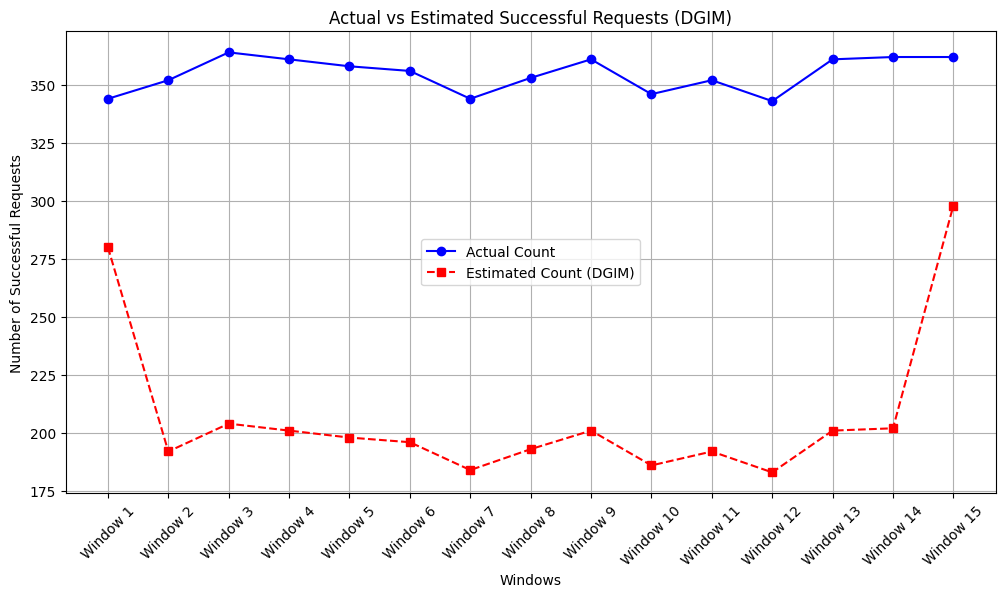

In [ ]:
import matplotlib.pyplot as plt

# Initialize tracking lists
actual_counts = []
estimated_counts = []
window_labels = []

# Reset DGIM
dgim = DGIM(window_size)

# Process in windows of 500 (up to 15 windows)
for i in range(0, min(len(binary_stream), 15 * window_size), window_size):
    window = binary_stream[i:i+window_size]

    # Count actual successes in the window
    actual_successes = sum(window)
    actual_counts.append(actual_successes)

    # Reset DGIM for each window (to compare fresh estimates)
    dgim = DGIM(window_size)
    for bit in window:
        dgim.add(bit)
    
    estimated_ones = dgim.estimate()
    estimated_counts.append(estimated_ones)

    # Store window label
    window_labels.append(f"Window {i//window_size + 1}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(window_labels, actual_counts, marker='o', label="Actual Count", color="blue")
plt.plot(window_labels, estimated_counts, marker='s', linestyle="dashed", label="Estimated Count (DGIM)", color="red")
plt.xlabel("Windows")
plt.ylabel("Number of Successful Requests")
plt.title("Actual vs Estimated Successful Requests (DGIM)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


## FM

In [ ]:
import hashlib
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Function to hash user IDs using specified hash function
def hash_user_id(user_id, hash_function):
    if hash_function == 'sha1':
        return hashlib.sha1(str(user_id).encode()).hexdigest()
    elif hash_function == 'sha256':
        return hashlib.sha256(str(user_id).encode()).hexdigest()
    elif hash_function == 'md5':
        return hashlib.md5(str(user_id).encode()).hexdigest()
    elif hash_function == 'sha224':
        return hashlib.sha224(str(user_id).encode()).hexdigest()
    else:
        raise ValueError("Unsupported hash function")

# Function to convert hexadecimal hash to binary with dynamic padding
def hex_to_binary(hex_str, bit_length):
    return bin(int(hex_str, 16))[2:].zfill(bit_length)

# Function to implement Flajolet-Martin algorithm
def flajolet_martin_algorithm(user_ids, hash_functions, correction_factor, num_trials):
    all_estimates = []
    
    # Define bit lengths for each hash function
    hash_bit_lengths = {'sha1': 160, 'sha256': 256, 'md5': 128, 'sha224': 224}

    for trial in range(num_trials):
        max_trailing_zeros_all_hashes = []

        for hf in hash_functions:
            max_trailing_zeros = 0
            
            for user_id in user_ids:
                hash_value = hash_user_id(user_id, hf)
                binary_hash = hex_to_binary(hash_value, hash_bit_lengths[hf])
                
                # Find the position of the rightmost 1 bit
                trailing_zeros = len(binary_hash) - len(binary_hash.rstrip('1'))
                
                if trailing_zeros > max_trailing_zeros:
                    max_trailing_zeros = trailing_zeros
            
            # Record the result for this hash function
            max_trailing_zeros_all_hashes.append(max_trailing_zeros)
        
        # Use median estimate from all hash functions
        median_trailing_zeros = np.median(max_trailing_zeros_all_hashes)
        estimate = 2 ** median_trailing_zeros
        
        # Apply correction factor
        corrected_estimate = estimate / correction_factor
        all_estimates.append(corrected_estimate)

    # Calculate the average estimate from multiple trials
    final_estimate = np.mean(all_estimates)
    return final_estimate

# Function to read data and process it
def process_data(file_path):
    # Read the CSV file into a DataFrame
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    # Extract UserID column as a list
    user_ids = df.select(col("UserID")).rdd.flatMap(lambda x: x).collect()
    
    # Calculate actual number of unique users
    actual_unique_users = df.select(col("UserID")).distinct().count()
    
    return user_ids, actual_unique_users

# Main function
def main():
    # Path to the dataset
    file_path = "Datasets/web_streaming_dataset.csv"
    
    # Process the data
    user_ids, actual_unique_users = process_data(file_path)
    
    # Define hash functions to use
    hash_functions = ['sha1', 'sha256', 'md5', 'sha224']
    
    # Flajolet-Martin with correction factor = 0.85 and 800 trials
    estimated_unique_users = flajolet_martin_algorithm(user_ids, hash_functions, correction_factor=0.65, num_trials=1000)
    
    # Print the results
    print(f"Actual number of unique users: {actual_unique_users}")
    print(f"Estimated number of unique users: {estimated_unique_users}")

# Run the main function
if __name__ == "__main__":
    main()

Actual number of unique users: 1491
Estimated number of unique users: 1575.3846153846155


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52362)
Traceback (most recent call last):
  File "c:\Users\HAMAHANG\anaconda3\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\HAMAHANG\anaconda3\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\HAMAHANG\anaconda3\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\HAMAHANG\anaconda3\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "c:\Users\HAMAHANG\anaconda3\Lib\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "c:\Users\HAMAHANG\anaconda3\Lib\site-packages\pyspark\accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "c:\Users\HAMAHANG\anaconda